In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Loading the data

In [54]:
# Train.csv has the Field_IDs needed to find the npy files
train_data = pd.read_csv('Train.csv')
print(train_data.shape)
train_data.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


This Dataset is radar data from 30 bands for 12 months.  
Each radar image is 41px a side, so total data shape for one field is [360, 41, 41].  
Radar image is not normal RGB image which is uint8, the value ranges from 0 to almost 10000.  
You can also use GPS quality for each field.  
For more information please see https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge/data

Loading data/image_arrays_train/QXZE577.npy as an array
Array shape: (360, 41, 40)


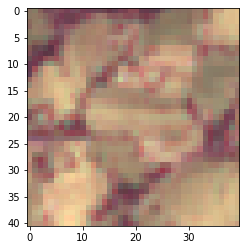

In [172]:
fid = train_data['Field_ID'].sample().values[0]
fn = f'data/image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

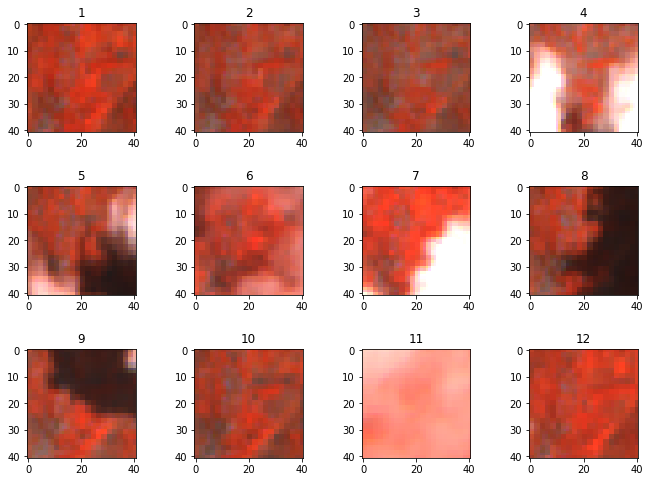

In [56]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
    rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
    rgb = rgb / 4000 # Scaling consistently 
    axs[i].imshow(rgb.clip(0, 1))
    axs[i].set_title(str(i+1))

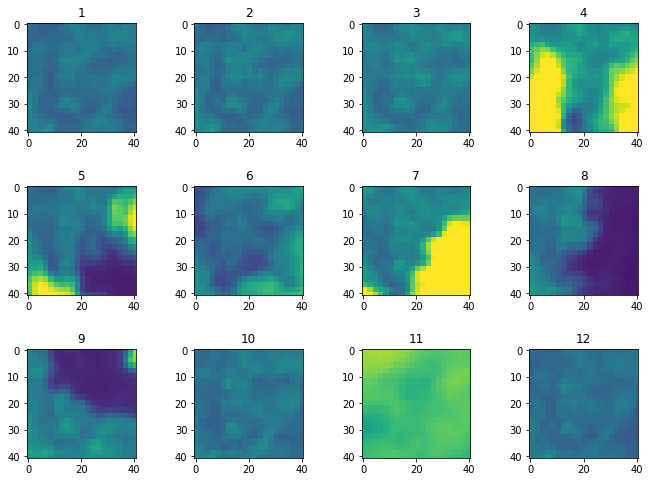

In [57]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
    cloud = arr[i*30 + 11]
    axs[i].imshow(cloud, vmin=0, vmax=4000)
    axs[i].set_title(str(i+1))

### Dense NN Model

In [324]:
def train(model, criterion, optim, train_dataloader):
    sum_loss = 0
    model = model.train()
    for (X, labels) in train_dataloader:
        X = X.to(device)
        y = labels.to(device)
        optim.zero_grad()
        output = model(X)
        loss = criterion(output, labels)
        loss.backward()
        optim.step()

        sum_loss += loss.item()

    avg_loss = sum_loss / len(train_dataloader)
    return avg_loss

def test(model, criterion, test_dataloader):
    sum_loss = 0

    model = model.eval()
    for (X, labels) in test_dataloader:
        X = X.to(device)
        labels = labels.to(device)

        output = model(X)
        loss = criterion(output, labels)

        sum_loss += loss.item()

    avg_loss = sum_loss / len(test_dataloader)
    return avg_loss

In [283]:
class CropVectorDataset(Dataset):
    def __init__(self, filenames:np.array, yields: torch.tensor=None, base_path='data/image_arrays_train'):
        super().__init__()
        self.filenames = filenames
        self.yields = yields
        self.base_path= base_path
    
    def __getitem__(self, idx):
        fid = self.filenames[idx]
        y = self.yields[idx] if self.yields is not None else []
        fn = f'{self.base_path}/{fid}.npy'
        arr = np.load(fn).astype(np.float32)
        vec=arr[:,20,20]/7000
#         normalize
        return torch.from_numpy(vec), y
    
    def __len__(self,) -> int:
        return self.filenames.shape[0]

In [323]:
class NN(nn.Module):
    def __init__(self, in_channel=360, hidden_channel=100):
        super().__init__()
        self.bn = nn.BatchNorm1d(in_channel)
        self.fc1 = nn.Linear(in_channel, hidden_channel)
        self.fc2 = nn.Linear(hidden_channel, hidden_channel)
        self.fc3 = nn.Linear(hidden_channel, 1)
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.bn(x)
        x =  self.relu(self.fc1(x))
        x = self.dropout(x)
        x =  self.relu(self.fc2(x))
        x = self.dropout(x)
        y =  self.fc3(x)
        return torch.flatten(y)

Set hyper parameters

In [325]:
batch_size=16
in_channel=360
hidden_channel=30
n_epoch = 10
lr=10**(-3.5)
device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'

In [327]:
yields = train_data['Yield'].values
y_std = yields.std()
y_mean = yields.mean()
y = (yields - yields.mean()) / yields.std()
X_train, X_val, y_train, y_val = train_test_split(train_data['Field_ID'].values, torch.from_numpy(y).float())
train_dataset = CropVectorDataset(filenames=X_train, yields=y_train)
val_dataset = CropVectorDataset(filenames=X_val, yields=y_val)
tdl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vdl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [332]:
model = NN(in_channel, hidden_channel).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0015)
criterion = nn.MSELoss()

### Fitting a model

In [ ]:
for epoch in range(n_epoch):
    mse = train(model, criterion, optim, tdl)
    print(f'Epoch {epoch+1}, Train Loss: {mse}')
    mse = test(model, criterion, vdl)
    print(f'Epoch {epoch+1}, Val Loss: {mse}')

### Saving Preds

In [ ]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')
test_dataset = CropVectorDataset(filenames=ss['Field_ID'].values, base_path='data/image_arrays_test')
test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

preds = np.zeros(len(ss))
count = 0
model.eval()
for data, _ in test_data_loader:
    preds[count:count+batch_size] = model(data).detach().cpu().numpy() * y_std + y_mean
    count += batch_size

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Sub.csv', index=False)

### CNN Model

In [361]:
class CropDataset(Dataset):
    def __init__(self, filenames:np.array, yields: torch.tensor=None, base_path='data/image_arrays_train'):
        super().__init__()
        self.filenames = filenames
        self.yields = yields
        self.base_path= base_path
    
    def __getitem__(self, idx):
        fid = self.filenames[idx]
        y = self.yields[idx] if self.yields is not None else []
        fn = f'{self.base_path}/{fid}.npy'
        arr = np.load(fn).astype(np.float32)
        arr=arr[:,:40,:40]
#         normalize
        arr = arr / 7000
        return torch.from_numpy(arr), y
    
    def __len__(self,) -> int:
        return self.filenames.shape[0]

In [350]:
class CNN(nn.Module):
    def __init__(self, in_channel=360, hidden_channel=30):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=hidden_channel, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=hidden_channel, out_channels=hidden_channel, kernel_size=5)
        self.fc1 = None
        self.fc2 = nn.Linear(500, 1)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        
        
    
    def forward(self, x):
        x =  self.relu(self.conv1(x))
        x =  self.pool(x)
        x = self.dropout(x)
        x =  self.relu(self.conv2(x))
        x =  self.pool(x)
        x = x.view(x.size(0), -1) 
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.shape[1], 500)
        x =  self.relu(self.fc1(x))
        x = self.dropout(x)
        y =  self.fc2(x)
        return torch.flatten(y)

Set hyper parameters

In [325]:
batch_size=16
in_channel=360
hidden_channel=30
n_epoch = 15
lr=10**(-3.5)
device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'

In [351]:
yields = train_data['Yield'].values
y_std = yields.std()
y_mean = yields.mean()
y = (yields - yields.mean()) / yields.std()
X_train, X_val, y_train, y_val = train_test_split(train_data['Field_ID'].values, torch.from_numpy(y).float())
train_dataset = CropDataset(filenames=X_train, yields=y_train)
val_dataset = CropDataset(filenames=X_val, yields=y_val)
tdl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vdl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [352]:
model = CNN(in_channel, hidden_channel).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0015)
criterion = nn.MSELoss()

### Fitting a model

In [357]:
for epoch in range(n_epoch):
    mse = train(model, criterion, optim, tdl)
    print(f'Epoch {epoch+1}, Train Loss: {mse}')
    mse = test(model, criterion, vdl)
    print(f'Epoch {epoch+1}, Val Loss: {mse}')

### Saving Preds

In [362]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')
test_dataset = CropDataset(filenames=ss['Field_ID'].values, base_path='data/image_arrays_test')
test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

preds = np.zeros(len(ss))
count = 0
model.eval()
for data, _ in test_data_loader:
    preds[count:count+batch_size] = model(data).detach().cpu().numpy() * y_std + y_mean
    count += batch_size

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Sub.csv', index=False)

Let's submit to https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge